# 手撕grpo

截图素材：https://zhuanlan.zhihu.com/p/24816372882 https://zhuanlan.zhihu.com/p/657693775

这个notebook的reward由规则给出，比如format，以及accury

只有actor模型，ref模型，没有critic模型

同时reward是基于规则给出的，所以没有rēward模型

定义参数配置

In [1]:
vocab_size = 50257
hidden_size = 128
intermediate_size = 256
num_hidden_layers = 2
num_attention_heads = 4
batch_size = 2
length_x = 5
max_new_tokens = 5
grpo_samples_nums = 2 # GRPO 采样数量，有的框架会把一张卡分给vllm，来让vllm加速生成

初始化ref 和actor模型

In [3]:
import torch
from transformers import GPT2Config, GPT2LMHeadModel

torch.manual_seed(1)

# 定义参数
vocab_size = 10
hidden_size = 128
intermediate_size = 256
num_hidden_layers = 2
num_attention_heads = 4

# 加载模型配置
config = GPT2Config(
    vocab_size=vocab_size,
    n_embd=hidden_size,
    n_inner=intermediate_size,
    n_layer=num_hidden_layers,
    n_head=num_attention_heads
)

# 初始化 GPT - 2 模型
model = GPT2LMHeadModel(config)
model_ref = GPT2LMHeadModel(config)
model.config.pad_token_id = model.config.eos_token_id
model_ref.config.pad_token_id = model_ref.config.eos_token_id

定义奖励函数

参考https://huggingface.co/docs/trl/main/en/grpo_trainer#looking-deeper-into-the-grpo-method

In [15]:
def reward_func_len(completions, **kwargs):
    """Reward function that gives higher scores to longer completions."""
    return [float(len(completion)) for completion in completions]

In [17]:
prompts = ["The sky is", "The sun is"]
completions = [" blue.", " in the sky."]
print(reward_func_len(prompts=prompts, completions=completions))

[6.0, 12.0]


In [27]:
import re

def format_reward_func(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<think>.*?</think><answer>.*?</answer>$"
    completion_contents = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, content) for content in completion_contents]
    return [1.0 if match else 0.0 for match in matches]

prompts = [
    [{"role": "assistant", "content": "What is the result of (1 + 2) * 4?"}],
    [{"role": "assistant", "content": "What is the result of (3 + 1) * 2?"}],
]
completions = [
    [{"role": "assistant", "content": "<think>The sum of 1 and 2 is 3, which we multiply by 4 to get 12.</think><answer>(1 + 2) * 4 = 12</answer>"}],
    [{"role": "assistant", "content": "The sum of 3 and 1 is 4, which we multiply by 2 to get 8. So (3 + 1) * 2 = 8."}],
]
format_reward_func(prompts=prompts, completions=completions)

[1.0, 0.0]

In [7]:
import re

def reward_func(completions, ground_truth, **kwargs):
    # Regular expression to capture content inside \boxed{}
    matches = [re.search(r"\\boxed\{(.*?)\}", completion) for completion in completions]
    contents = [match.group(1) if match else "" for match in matches]
    # Reward 1 if the content is the same as the ground truth, 0 otherwise
    return [1.0 if c == gt else 0.0 for c, gt in zip(contents, ground_truth)]

prompts = ["Problem: Solve the equation $2x + 3 = 7$. Solution:", "Problem: Solve the equation $3x - 5 = 10$."]
completions = [r" The solution is \boxed{2}.", r" The solution is \boxed{6}."]
ground_truth = ["2", "5"]
reward_func(prompts=prompts, completions=completions, ground_truth=ground_truth)

[1.0, 0.0]

以下是使用 GRPOTrainer 中多个奖励函数的示例。在这个例子中，我们定义了两个特定任务的奖励函数： math_reward_func 和 coding_reward_func 。 math_reward_func 奖励基于正确性的数学问题，而 coding_reward_func 奖励基于解决方案是否工作的编程问题。

不过check_math_solution 以及 test_code_solution要自己写

In [9]:
from datasets import Dataset
from trl import GRPOTrainer

# Define a dataset that contains both math and coding problems
dataset = Dataset.from_list(
    [
        {"prompt": "What is 2+2?", "task": "math"},
        {"prompt": "Write a function that returns the sum of two numbers.", "task": "code"},
        {"prompt": "What is 3*4?", "task": "math"},
        {"prompt": "Write a function that returns the product of two numbers.", "task": "code"},
    ]
)

# Math-specific reward function
def math_reward_func(prompts, completions, task, **kwargs):
    rewards = []
    for prompt, completion, t in zip(prompts, completions, task):
        if t == "math":
            # Calculate math-specific reward
            correct = check_math_solution(prompt, completion)
            reward = 1.0 if correct else -1.0
            rewards.append(reward)
        else:
            # Return None for non-math tasks
            rewards.append(None)
    return rewards

# Coding-specific reward function
def coding_reward_func(prompts, completions, task, **kwargs):
    rewards = []
    for prompt, completion, t in zip(prompts, completions, task):
        if t == "coding":
            # Calculate coding-specific reward
            works = test_code_solution(prompt, completion)
            reward = 1.0 if works else -1.0
            rewards.append(reward)
        else:
            # Return None for non-coding tasks
            rewards.append(None)
    return rewards

# # Use both task-specific reward functions
# trainer = GRPOTrainer(
#     model="Qwen/Qwen2-0.5B-Instruct",
#     reward_funcs=[math_reward_func, coding_reward_func],
#     train_dataset=dataset,
# )

# trainer.train()

[2025-03-31 22:07:42,665] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to mps (auto detect)


W0331 22:07:42.977000 8626851648 torch/distributed/elastic/multiprocessing/redirects.py:28] NOTE: Redirects are currently not supported in Windows or MacOs.


## grpo把critic model使用基于规定的优势函数计算来替换掉了

可以看到我们需要先准备一批oi才能计算出优势函数

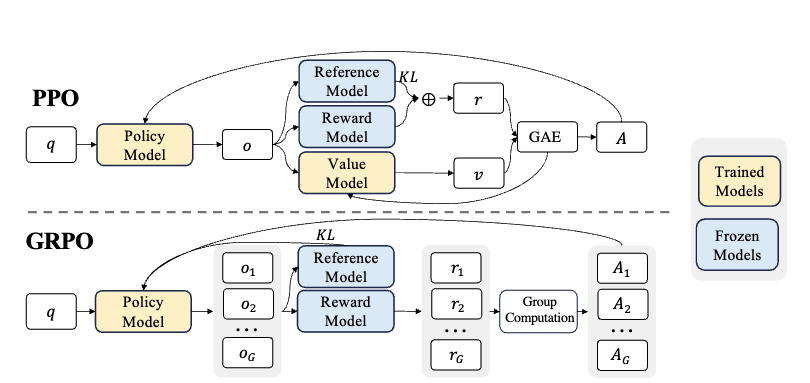

一般情况下，比如trl是可以通过vllm来生成一批数据，我们复制一波输入然后model generate一批就行，在此刻就随便搞一波就行，

In [10]:
def get_response(model, prompt, max_new_tokens):
    inputs = {'input_ids': prompt}  # ignore mask，好像不需要mask
    y = model.generate(**inputs,
                       max_new_tokens=max_new_tokens,
                       # forced_eos_token_id=True
                       )
    return y

这个notebook真实数据不好写（带think以及answer标签），就写个大概

In [12]:
input_x = [{"prompt": "What is 2+2?", "task": "math"},
        {"prompt": "Write a function that returns the sum of two numbers.", "task": "code"},
        {"prompt": "What is 3*4?", "task": "math"},
        {"prompt": "Write a function that returns the product of two numbers.", "task": "code"}]

调用一个get_response，生成一批output_x

In [21]:
# 假设模型生成的response
output_x = ["<think>The sum of 1 and 2 is 3, which we multiply by 4 to get 12.</think><answer>(1 + 2) * 4 = 12</answer>",
            "The sum of 3 and 1 is 4, which we multiply by 2 to get 8. So (3 + 1) * 2 = 8.",
            "<think>The product of 3 and 4 is 12.</think><answer>3 * 4 = 12</answer>",
            "The product of 3 and 4 is 12. So 3 * 4 = 12."]

我们现在有一组数据后就要得到reward

In [29]:
len_rewards = reward_func_len(completions=output_x)

In [30]:
def reward_func_format(completions, **kwargs):
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<think>.*?</think><answer>.*?</answer>$"
    completion_contents = [completion for completion in completions]
    matches = [re.match(pattern, content) for content in completion_contents]
    return [1.0 if match else 0.0 for match in matches]
format_rewards = reward_func_format(completions=output_x)

对每组奖励进行计算优势函数


$$\hat{A}_{i,t} = \frac{r_i - \text{mean}(\mathbf{r})}{\text{std}(\mathbf{r})}$$ 

In [31]:
def grpo_advantage(rewards):
    epsilon = 0.01
    rewards = torch.tensor(rewards) 
    A = (rewards - rewards.mean()) / (rewards.std() + epsilon)
    return A

advantage_len = grpo_advantage(len_rewards)
print(advantage_len)
advantage_format = grpo_advantage(format_rewards)
print(advantage_format)

tensor([ 1.2379,  0.0982, -0.1375, -1.1986])
tensor([ 0.8513, -0.8513,  0.8513, -0.8513])


剩下的流程其实与ppo相同，不太想写了

$$\mathbb{D}_{\text{KL}}\left[\pi_\theta \|\pi_{\text{ref}}\right] = \frac{\pi_{\text{ref}}(o_{i,t} \mid q, o_{i,<t})}{\pi_\theta(o_{i,t} \mid q, o_{i,<t})} - \log \frac{\pi_{\text{ref}}(o_{i,t} \mid q, o_{i,<t})}{\pi_\theta(o_{i,t} \mid q, o_{i,<t})} - 1,
$$

In [32]:
prompt = torch.randint(0, vocab_size, (batch_size, length_x))
response = torch.randint(0, vocab_size, (batch_size, length_x + max_new_tokens))

In [33]:
attention_mask = torch.ones(batch_size, length_x+max_new_tokens)
attention_mask[:, :length_x] = 0
print(attention_mask)

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])


In [34]:
import torch.nn.functional as F

def get_logits(model, input_ids):
    # 得到logits
    outputs = model(input_ids=input_ids)
    logits = outputs.logits
    return logits

def get_logprobs(model, response, attention_mask):
    # 得到logprobs
    logits = get_logits(model, response)
    # F.log_softmax() 是先进行softmax运算然后再取对数（log）
    all_token_logprobs = F.log_softmax(logits, dim=-1)
    # 使用torch.gather() 从logprobs中收集response的值
    gathered = torch.gather(all_token_logprobs, 2, response.unsqueeze(2))
    # 去掉最后一个维度
    response_logprobs = gathered.squeeze(-1)
    return response_logprobs

In [36]:
get_logprobs(model, response, attention_mask)

tensor([[-1.6183, -1.3673, -1.5195, -1.5547, -1.4089, -1.3429, -1.2517, -1.3878,
         -1.3432, -1.1901],
        [-1.8480, -1.5877, -1.3003, -1.3325, -1.6356, -1.7515, -1.4456, -1.4905,
         -1.2200, -1.4700]], grad_fn=<SqueezeBackward1>)

In [37]:
def grpo_kl(pi, pi_ref):
    x1 = pi_ref.exp() / pi.exp()
    x2 = pi_ref - pi
    return x1 - x2 - 1

pi = get_logprobs(model, response, attention_mask)
pi_ref = get_logprobs(model_ref, response, attention_mask)
grpo_kl(pi, pi_ref)

tensor([[2.6098e-02, 4.7684e-05, 4.6487e-03, 1.6298e-03, 3.6643e-03, 6.2504e-03,
         2.8181e-04, 2.8575e-02, 2.9539e-02, 3.2508e-02],
        [1.3051e-02, 1.5891e-04, 4.1568e-02, 7.6652e-05, 1.7810e-04, 1.0834e-01,
         4.0960e-04, 4.0464e-02, 2.9019e-02, 7.3563e-02]],
       grad_fn=<SubBackward0>)

loss

$$
\mathcal{L}_{\text{GRPO}}(\theta) = - \frac{1}{G} \sum_{i=1}^G \frac{1}{|o_i|} \sum_{t=1}^{|o_i|} \left[ \min \left( \frac{\pi_\theta(o_{i,t} \mid q, o_{i,< t})}{\pi_{\theta_{\text{old}}}(o_{i,t} \mid q, o_{i,< t})} \hat{A}_{i,t}, \, \text{clip}\left( \frac{\pi_\theta(o_{i,t} \mid q, o_{i,< t})}{\pi_{\theta_{\text{old}}}(o_{i,t} \mid q, o_{i,< t})}, 1 - \epsilon, 1 + \epsilon \right) \hat{A}_{i,t} \right) - \beta \mathbb{D}_{\text{KL}}\left[\pi_\theta \| \pi_{\text{ref}}\right] \right],
$$

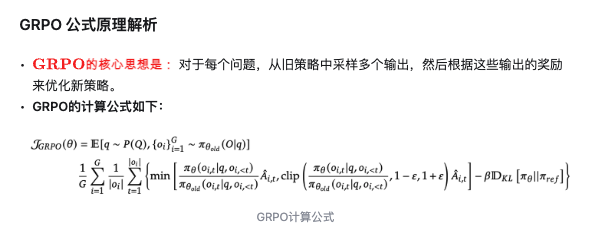

超参数

epslion = 0.01

beta = 0.1



In [57]:
group_num, len_oi = pi.shape

In [58]:
len_oi = len_oi - length_x

In [59]:
len_oi

5

In [60]:
len_oi = torch.tensor([len_oi] * group_num, dtype = torch.long)
len_oi



tensor([5, 5])

In [61]:
attention_mask

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])

In [64]:
epslion = 0.01
beta = 0.01

In [65]:
test_rewards = [100,66]
test_rewards = torch.tensor(len_rewards,dtype = torch.float)
advantage_test = grpo_advantage(test_rewards)

/var/folders/_k/crvl81qd02z3lyvty3mgfwxw0000gn/T/ipykernel_52429/710462030.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_rewards = torch.tensor(len_rewards,dtype = torch.float)
/var/folders/_k/crvl81qd02z3lyvty3mgfwxw0000gn/T/ipykernel_52429/1779594425.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards)


In [66]:
advantage_test = advantage_test.unsqueeze(dim = 1) 

ratio = pi.exp() / pi_ref.exp()
ratio_clip = torch.clamp(ratio, 1 - epslion, 1 + epslion)

policy_gradient = torch.minimum(ratio * advantage_test , ratio_clip * advantage_test)
kl = grpo_kl(pi, pi_ref)

In [68]:
ratio_clip

tensor([[0.9900, 1.0098, 0.9900, 1.0100, 0.9900, 1.0100, 0.9900, 0.9900, 0.9900,
         1.0100],
        [0.9900, 0.9900, 1.0100, 0.9900, 1.0100, 0.9900, 1.0100, 0.9900, 1.0100,
         0.9900]], grad_fn=<ClampBackward1>)

In [67]:
policy_gradient

tensor([[ 0.5672,  0.7138,  0.6428,  0.7139,  0.6496,  0.7139,  0.6903,  0.5616,
          0.5596,  0.7139],
        [-0.6997, -0.6997, -0.9569, -0.6997, -0.7203, -0.6997, -0.7274, -0.6997,
         -0.9085, -0.6997]], grad_fn=<MinimumBackward0>)

In [69]:
kl

tensor([[2.6098e-02, 4.7684e-05, 4.6487e-03, 1.6298e-03, 3.6643e-03, 6.2504e-03,
         2.8181e-04, 2.8575e-02, 2.9539e-02, 3.2508e-02],
        [1.3051e-02, 1.5891e-04, 4.1568e-02, 7.6652e-05, 1.7810e-04, 1.0834e-01,
         4.0960e-04, 4.0464e-02, 2.9019e-02, 7.3563e-02]],
       grad_fn=<SubBackward0>)

In [71]:
loss = (policy_gradient -  beta * kl) * attention_mask
loss

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7138,  0.6903,  0.5614,
          0.5593,  0.7136],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.7008, -0.7274, -0.7001,
         -0.9087, -0.7005]], grad_fn=<MulBackward0>)

In [72]:
len_oi.unsqueeze(dim = 1)


tensor([[5],
        [5]])

In [73]:
def grpo_loss(pi, pi_old, pi_ref, advantage, length_x, mask):
    epslion = 0.01
    beta = 0.01

    advantage = advantage.unsqueeze(dim = 1) 

    ratio = pi.exp() / pi_old.exp()
    ratio_clip = torch.clamp(ratio, 1 - epslion, 1 + epslion)

    policy_gradient = torch.minimum(ratio * advantage , ratio_clip * advantage)
    kl = grpo_kl(pi, pi_ref)

    group_num, len_oi = pi.shape  
    
    len_oi = len_oi - length_x
    len_oi = torch.tensor([len_oi] * group_num, dtype = torch.long)

    loss = (policy_gradient -  beta * kl) * mask
    loss = (- 1 / group_num ) * loss / len_oi.unsqueeze(dim = 1)
    loss = loss.sum()

    return loss


In [74]:
pi_logprob.shape

torch.Size([2, 10])

因为response是自己定义的

但之前的rewards是基于output_x的，所以需要转换

随便设置一个rewards

In [75]:
response

tensor([[9, 2, 7, 8, 7, 5, 5, 9, 3, 3],
        [4, 3, 8, 6, 8, 7, 6, 1, 6, 7]])

In [76]:
len_rewards

tensor([100.,  66.])

In [77]:
len_rewards = [100,66]
len_rewards = torch.tensor(len_rewards,dtype = torch.float)

In [78]:
pi_logprob = get_logprobs(model, response, attention_mask)
pi_old_logprob = get_logprobs(model, response, attention_mask)
print(pi_logprob == pi_old_logprob)
pi_ref_logprob = get_logprobs(model_ref, response, attention_mask)

len_advantage = grpo_advantage(len_rewards)
loss = grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, len_advantage, length_x, attention_mask)     # 应该是 [B]（然后才可以 unsqueeze 到 [B, 1]）

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False]])


/var/folders/_k/crvl81qd02z3lyvty3mgfwxw0000gn/T/ipykernel_52429/1779594425.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards)


In [79]:
loss

tensor(0.0352, grad_fn=<SumBackward0>)

: 

## grpo采样